# A/B Testing - PA Bond

# 0.0. Planejamento

##  Electronic House 
é um e-commerce de produtos de informática para casas e escritórios. Os clientes podem comprar mouses, monitores, teclados, computadores, laptops, cabos HDMI, fones de ouvido, cameras webcam, entre outros, através de um site online e recebem os produtos no conforto de suas casas.
O time de UX designers vem trabalhando em uma nova página de vendas, com o objetivo de aumentar a taxa de conversão de um produto da loja, um teclado bluetooth. O product manager (gerente de produto) disse que a taxa de conversão
da página atual é de 13% em média, no último ano. O objetivo do product manager é aumentar a taxa de conversão em 2%, ou seja, a nova página de vendas, desenvolvida pelo time de UX, seria um sucesso se a sua taxa de conversão fosse de 15%. O teclado bluetooth possui um preço de venda de R$ 4.500,00 à vista ou parcelado em 12% sem juros no cartão de crédito. Antes de trocar a página de vendas antiga pela nova, o product manager gostaria de testar a efetividade da nova página em um grupo menor de clientes, a fim de correr menos riscos de queda da conversão, caso a página nova mostre uma conversão pior do que a página atual.

## Desafio

Você foi contratado como um freelancer pela Electronic House para ajudar o time de
Designers da nova página, a validar a sua efetividade de uma maneira mais segura,
com mais confiança e rigidez na análise.
Os entregáveis do seu trabalho são os seguintes:
1. A conversão da nova página é realmente melhor do a conversão da página
atual?
2. Qual o potencial de número de vendas que a nova página pode trazer?
3. Qual o faturamento total na venda do teclado bluetooth através da nova página?

## 0.1. Imports

In [130]:
import pandas as pd
import numpy as np
import pingouin as pg

from scipy import stats

from matplotlib import pyplot as plt
from statsmodels.stats import api as sms

## 0.2. Function

In [107]:
def data_filter( dataframe, country=False, Country=""):
    if country:
        dataframe = dataframe[dataframe["country"] == Country]
    return dataframe

# 1.0. Design do Experimento 

In [108]:
# Objetivo: Definir se preenchimento automático da página de checkout é melhor do que o preenchimento manual.
# Métrica: GMV ( Gross Margin Revenue ) médio

# Group A = Preenchimento automático
# Group B = Preenchimento manual

## 1.1. Hipótese do Experimento

In [109]:
H0: avg GMV A  =  avg GMV B
H1: avg GMV A < > avg GMV B

SyntaxError: invalid syntax (1580725675.py, line 1)

## 1.2. Definindo o Tamanho da Amostra

In [110]:
#p1 = 0.75
#p2 = 0.80

# init_metric = metric atual ( media do GMV, media Sales )
# end_metric = metric lift ( 5% sobre a metric actual )

init_metric = 1902.86
end_metric  = init_metric + ( init_metric * 0.05 )
std_metric = 1398.88

effect_size = ( end_metric - init_metric ) / std_metric

sample_size =  sms.tt_ind_solve_power( 
    effect_size=effect_size,
    alpha=0.05,
    power=0.80
)

sample_size =  np.ceil( sample_size ).astype( int )
print(  sample_size  )

3395


# 2.0. Preparação dos dados 

## 2.1. Loading Data

In [111]:
df = pd.read_csv( 'datasets/ab_testing.csv' )

In [112]:
# Filter Country
df2 = data_filter( df, True, 'BRA' )
df2.head()

,uid,country,gender,spent,purchases,date,group,device
12,11143138,BRA,M,2592,8,2015-05-20,GRP B,A
15,11148343,BRA,M,299,1,2016-09-04,GRP B,A
31,11172970,BRA,M,1797,3,2017-07-05,GRP B,I
36,11177332,BRA,M,1994,6,2017-01-06,GRP B,I
37,11179295,BRA,M,1198,2,2017-12-19,GRP B,A


## 2.2. Descriptive Statistics

In [113]:
print( f'Number of Rows: {df2.shape[0]}' )
print( f'Number of Cols: {df2.shape[1]}' )

Number of Rows: 9009
Number of Cols: 8


In [114]:
df2[['uid', 'group']].groupby( 'group' ).count().reset_index()

,group,uid
0,GRP A,4518
1,GRP B,4491


In [115]:
df2['spent'].agg( ['mean', 'std'] )

mean    1902.860251
std     1398.886279
Name: spent, dtype: float64

### 2.2.1. Check NA

In [116]:
df2.isna().sum()

uid          0
country      0
gender       0
spent        0
purchases    0
date         0
group        0
device       0
dtype: int64

### 2.2.2. Check Unidade Experimental ( pessoas )

In [117]:
df2[['uid', 'group']].groupby( 'uid' ).count().reset_index().query( 'group > 1' )

,uid,group


### 2.2.3. Control and Treatment Homogenity

In [118]:
df2[['uid', 'group', 'gender']].groupby( ['group', 'gender'] ).count()

uid
group gender      
GRP A F       2213
      M       2305
GRP B F       2208
      M       2283

In [119]:
df2[['uid', 'group', 'device']].groupby( ['group', 'device'] ).count()

uid
group device      
GRP A A       2208
      I       2310
GRP B A       2284
      I       2207

In [120]:
df2.groupby( 'group' ).agg( {'country':   'count',
                             'spent':     ['min', 'max', 'mean', 'std'],
                             'purchases': ['min', 'max', 'mean', 'std'] } )

country spent                                  purchases                \
        count   min    max         mean          std       min max      mean   
group                                                                          
GRP A    4518    99  10480  1899.792165  1413.074052         1  24  4.568172   
GRP B    4491    99  10478  1905.946782  1384.617019         1  23  4.585393   

                 
            std  
group            
GRP A  3.170057  
GRP B  3.132202

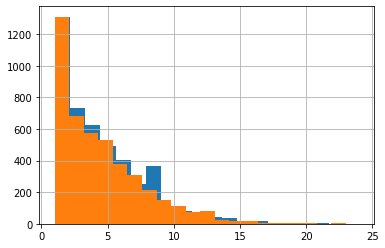

In [121]:
df2.loc[df2['group'] == 'GRP A', 'purchases'].hist( bins=20 );
df2.loc[df2['group'] == 'GRP B', 'purchases'].hist( bins=20 );

# 3.0. Test Hipótese

## 3.1. Groups

In [129]:
sample_A = df2.loc[df2['group'] == 'GRP A', 'spent'].sample( n=sample_size, random_state=42 )
sample_B = df2.loc[df2['group'] == 'GRP B', 'spent'].sample( n=sample_size, random_state=42 )

# Metrics 
print( f'AVG Sample A +/-{ np.round( sample_A.mean(), 2) }, { np.round( sample_A.std(),2 ) }')
print( f'AVG Sample B +/-{ np.round( sample_B.mean(), 2) }, { np.round( sample_B.std(),2 ) }')

AVG Sample A +/-1908.56, 1406.42
AVG Sample B +/-1902.1, 1383.93


## 3.2. Inferencia Estatística

In [131]:
t_test, p_value = stats.ttest_ind( sample_A, sample_B )
print( f'p-value {p_value}')

p-value 0.8488440918718094


# 4.0. Conclusão 

In [139]:
significance_level = 0.5
if p_value < significance_level:
    print( f'Reject Null Hypothesis' )
    print( f'O preenchimento automático troxe uma mudança significativa no GMV médio da página' ) 
    print( f'Booooua - Podemos liberar a página para toda a audiência do site' ) 
else:    
    print( f'Falied to Reject Null Hypothesis ( Assumir a Hipótese Nula)' ) 
    print( f'Não temos evidência suficiente para dizer que o preenchimento automático trouxe uma mudança..') 
    print( f'Repensar a estratégia do dispositivo de preechimento automático') 
    

Falied to Reject Null Hypothesis ( Assumir a Hipótese Nula)
Não temos evidência suficiente para dizer que o preenchimento automático trouxe uma mudança..
Repensar a estratégia do dispositivo de preechimento automático


In [136]:
# salario + beneficios
salario = 2500
insalubridade = 480 
bonus = 110

salario_total = salario + insalubridade + bonus 
print( f'R$:{salario_total}')

R$:3090


In [142]:
# descontos
# De R$ 2.427,36 a R$ 3.614,03 -> 12%
# De R$ 3.641,03 a R$ 7.087,22 -> 14%
inss = 0.14
pensao = 400

desconto_inss = salario_total * inss
print( f'INSS:   -{ desconto_inss }')
print( f'Pensão: -{pensao}')

salario_liquido = salario_total - desconto_inss - pensao
print( f'Salario liquido: {salario_liquido}')

INSS:   -432.6
Pensão: -400
Salario liquido: 2257.4


In [143]:
# despesas
refeicao = 12 * 30
agua_luz_internet = 200
print( f'Gastos com comida: -{refeicao}')
print( f'Gastos agua, luz, internet: -{agua_luz_internet}')
salario_liquido = salario_liquido - refeicao - agua_luz_internet
salario_liquido

Gastos com comida: -360
Gastos agua, luz, internet: -200


1697.4